
<p align="center">
    <img src="https://github.com/GeostatsGuy/GeostatsPy/blob/master/TCG_color_logo.png?raw=true" width="220" height="240" />

</p>

 

## Spatial Correlation-based Anomaly Detection Method for Subsurface Modeling

#### Wendi Liu, Graduate Student, The University of Texas at Austin

##### [LinkedIn](https://www.linkedin.com/in/wendi-liu-8a3023127/) | [GeostatsPy](https://github.com/GeostatsGuy/GeostatsPy)

#### Michael Pyrcz, Associate Professor, University of Texas at Austin 

##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1) | [GeostatsPy](https://github.com/GeostatsGuy/GeostatsPy)



### Abstract
Spatial data analytics provides new opportunities for automated detection of anomalous data for data quality control and subsurface segmentation to reduce uncertainty in spatial models. Solely data-driven anomaly detection methods do not fully integrate spatial concepts such as spatial continuity and data sparsity. Also, data-driven anomaly detection methods are challenged in integrating critical geoscience and engineering expertise knowledge.

The proposed spatial anomaly detection method is based on the semivariogram spatial continuity model derived from sparsely sampled well data and geological interpretations. The method calculates the lag joint cumulative probability for each matched pair of spatial data, given their lag vector and the semivariogram under the assumption of bivariate Gaussian distribution. For each combination of paired spatial data, the associated head and tail Gaussian standardized values of a pair of spatial data is mapped to the joint probability density function informed from the lag vector and semivariogram. The paired data are classified as anomalous if the associated head and tail Gaussian standardized values locate within a low probability zone. The anomaly decision threshold can be decided based on a loss function quantifying the cost of overestimation or underestimation. 

The proposed spatial correlation anomaly detection method is able to integrate domain expertise knowledge through trend and correlogram models with sparse, spatial data to identify anomalous samples, region, segmentation boundaries or facies transition zones. This is a useful automation tool to identify samples in big spatial data to focus professional attention.


#### Loading functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt                          
import random as rand
import math
import seaborn as sns
import scipy as sp
import scipy.stats as st
from scipy.spatial import Delaunay
from scipy.stats import norm
import geostatspy.GSLIB as GSLIB                       # GSLIB utilies, visualization and wrapper
import geostatspy.geostats as geostats                 # GSLIB methods convert to Python
from matplotlib import rc
rc('font', family='Arial', size=15,weight='bold')
"""
Functions
"""
from matplotlib.colors import Normalize
# Utility function to move the midpoint of a colormap to be around
# the values of interest.

class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))




# sample with provided X and Y and append to DataFrame   
def sample(array,xmin,xmax,ymin,ymax,step,name,df,xcol,ycol):
    if array.ndim == 2:
        ny = (array.shape[0])
        nx = (array.shape[1])
    else:
        print('Array must be 2D')
    x = []; y = []; v = []
    nsamp = len(df)
    for isamp in range(0,nsamp):
        x = df.iloc[isamp][xcol]
        y = df.iloc[isamp][ycol]
        iy = min(ny - int((y - ymin)/step) - 1,ny-1)
        ix = min(int((x - xmin)/step), nx - 1)
        v.append(array[iy,ix])
    df[name] = v
    return(df) 
# extract regular spaced samples from a model   
def regular_sample(array,xmin,xmax,ymin,ymax,step,mx,my,name):
    x = []; y = []; v = []; iix = 0; iiy = 0;
    xx, yy = np.meshgrid(np.arange(xmin, xmax, step),np.arange(ymax, ymin, -1*step))
    iiy = 0
    for iy in range(0,ny):
        if iiy >= my:
            iix = 0
            for ix in range(0,nx):
                if iix >= mx:
                    x.append(xx[ix,iy]);y.append(yy[ix,iy]); v.append(array[ix,iy])
                    iix = 0; iiy = 0
                iix = iix + 1
        iiy = iiy + 1
    df = pd.DataFrame(np.c_[x,y,v],columns=['X', 'Y', name])
    return(df)

# extract random samples from a model  
def random_sample(array,xmin,xmax,ymin,ymax,step,nsamp,name):
    import random as rand
    x = []; y = []; v = []; iix = 0; iiy = 0;
    xx, yy = np.meshgrid(np.arange(xmin, xmax, step),np.arange(ymax-1, ymin-1, -1*step))
    ny = xx.shape[0]
    nx = xx.shape[1]
    sample_index = rand.sample(range((nx)*(ny)), nsamp)
    for isamp in range(0,nsamp):
        iy = int(sample_index[isamp]/ny)
        ix = sample_index[isamp] - iy*nx
        x.append(xx[iy,ix])
        y.append(yy[iy,ix])
        v.append(array[iy,ix])
    df = pd.DataFrame(np.c_[x,y,v],columns=['X', 'Y', name])
    return(df) 

def sqdist3(x1,y1,z1,x2,y2,z2,ind,rotmat):
    """Squared Anisotropic Distance Calculation Given Matrix Indicator
    
    This routine calculates the anisotropic distance between two points 
    given the coordinates of each point and a definition of the
    anisotropy.
    
    INPUT VARIABLES:
 
    x1,y1,z1         Coordinates of first point
    x2,y2,z2         Coordinates of second point
    ind              The rotation matrix to use
    rotmat           The rotation matrices"""
    
    dx = x1 - x2
    dy = y1 - y2
    dz = z1 - z2
    sqdist = 0.0
    for i in range(3):
        cont = rotmat[ind, i, 0] * dx + rotmat[ind, i, 1] * dy + rotmat[ind, i, 2] * dz
        sqdist += cont**2
    return sqdist

def setrot3(ang1,ang2,ang3,anis1,anis2,ind,rotmat):
    """Sets up an Anisotropic Rotation Matrix
    
    Sets up the matrix to transform cartesian coordinates to coordinates
    accounting for angles and anisotropy
    
    INPUT PARAMETERS:

    ang1             Azimuth angle for principal direction
    ang2             Dip angle for principal direction
    ang3             Third rotation angle
    anis1            First anisotropy ratio
    anis2            Second anisotropy ratio
    ind              matrix indicator to initialize
    rotmat           rotation matrices
    
    Converts the input angles to three angles which make more mathematical sense:

          alpha   angle between the major axis of anisotropy and the
                  E-W axis. Note: Counter clockwise is positive.
          beta    angle between major axis and the horizontal plane.
                  (The dip of the ellipsoid measured positive down)
          theta   Angle of rotation of minor axis about the major axis
                  of the ellipsoid."""
    
    DEG2RAD=np.pi/180.0; EPSLON=1e-20
    if (ang1 >= 0.0)&(ang1<270.0):
        alpha = (90.0 - ang1) * DEG2RAD
    else:
        alpha = (450.0 - ang1) * DEG2RAD
    beta = -1.0 * ang2 *DEG2RAD
    theta = ang3 * DEG2RAD
    
    sina = np.sin(alpha)
    sinb = np.sin(beta)
    sint = np.sin(theta)
    cosa = np.cos(alpha)
    cosb = np.cos(beta)
    cost = np.cos(theta)
    ### Construct the rotation matrix in the required memory
    
    afac1 = 1.0/max(anis1, EPSLON)
    afac2 = 1.0/max(anis2, EPSLON)
    rotmat[ind,0,0] = cosb * cosa
    rotmat[ind,0,1] = cosb * sina
    rotmat[ind,0,2] = -sinb
    rotmat[ind,1,0] = afac1*(-cost*sina + sint*sinb*cosa)
    rotmat[ind,1,1] = afac1*(cost*cosa + sint*sinb*sina)
    rotmat[ind,1,2] = afac1*( sint * cosb)
    rotmat[ind,2,0] = afac2*(sint*sina + cost*sinb*cosa)
    rotmat[ind,2,1] = afac2*(-sint*cosa + cost*sinb*sina)
    rotmat[ind,2,2] = afac2*(cost * cosb)
    
    return rotmat

def cova3(x1,y1,z1,x2,y2,z2,nst,c0,it,cc,aa,rotmat,cmax,ivarg=1,irot=0, MAXNST=4):
    """Covariance Between Two Points
    This function calculated the covariance associated with a variogram
  model specified by a nugget effect and nested varigoram structures.
  The anisotropy definition can be different for each nested structure."""
    
    """
    INPUT VARIABLES:

    x1,y1,z1         coordinates of first point
    x2,y2,z2         coordinates of second point
    nst             number of nested structures (maximum of 4)
    ivarg            variogram number (set to 1 unless doing cokriging
                        or indicator kriging)
    MAXNST           size of variogram parameter arrays
    c0              isotropic nugget constant
    it               type of each nested structure:
                       1. spherical model of range a;
                       2. exponential model of parameter a;
                            i.e. practical range is 3a
                       3. gaussian model of parameter a;
                            i.e. practical range is a*sqrt(3)
                       4. power model of power a (a must be greater than 0  and
                            less than 2).  if linear model, a=1,c=slope.
    cc               multiplicative factor of each nested structure.
                       (sill-c0) for spherical, exponential,and gaussian
                       slope for linear model.
    aa               parameter "a" of each nested structure.
    irot             index of the rotation matrix for the first nested 
                     structure (irot starts from 0; the second nested structure will use
                     irot+1, the third irot+2, and so on)
    rotmat           rotation matrices"""
    
    EPSLON = 1e-10
    PMX=1e10
    ### Calculate the maximum covariance value (used for zero distances and for power model covariance):
    istart = 1+ (ivarg-1) * MAXNST
    
    for ii in range(nst):##nst[ivarg-1] if ivarg>1
        ist = istart+ ii-1
        if it[ist] == 4:
            cmax = cmax+PMX
        else:
            cmax = cmax+cc[ist]
        
    # Check for very small distance
    hsqd = sqdist3(x1,y1,z1,x2,y2,z2,irot,rotmat)
    if hsqd < EPSLON:
        cova = cmax
        return cmax,cova
    
    # Non-zero distance, loop over all the structures
    cova = 0.0
    for js in range(nst):##nst[ivarg-1] if ivarg>1
        ist = istart+js-1
        # Compute the appropriate structural distance
#         if ist!=0:
#             ir = min((irot+js),MAXROT)
#             hsqd = sqdist(x1,y1,z1,x2,y2,z2,ir,MAXROT,rotmat)
        h = np.sqrt(hsqd)
        if it[ist] == 1: ##Spherical
            hr = h/aa[ist]
            if hr<1:
                cova+=cc[ist]*(1.0-hr*(1.5-0.5*hr*hr))
        elif it[ist] == 2: ##Exponential
            cova += cc[ist]*np.exp(-3.0*h/aa[ist])
        elif it[ist] == 3: ##Gaussian
            cova += cc[ist]*np.exp(-(3.0*h/aa[ist])*(3.0*h/aa[ist]))
        elif it[ist] == 4: ##Power
            cova += cmax-cc[ist]*h**aa[ist]
            
    return cmax, cova
### calculate correlogram from experimental variogram
def correlavario(x1, y1, x2, y2,nst=2,c0=0,azi =112.5, it=[1,1],cc=[0.4,0.6],hmaj=[170,1100],hmin = [170,400],hvert=[0,0]):
    ###Initialization
    rotmat = np.zeros((5, 3, 3))
    EPSLON = 1.0e-20
    MAXNST=4
    maxcov=1.0
    cmax = c0
    ang1 = np.ones((MAXNST,))*azi #azimuth
    ang2 = np.zeros((MAXNST,)) #dip
    ang3 = np.zeros((MAXNST,)) #plenge
    anis1 = np.zeros((MAXNST,))
    anis2 = np.zeros((MAXNST,))
    
    for i in range(nst):
        anis1[i] = hmin[i]/max(hmaj[i],EPSLON)
        anis2[i] = hvert[i]/max(hmaj[i],EPSLON)
        rotmat = setrot3(ang1[i],ang2[i],ang3[i],anis1[i],anis2[i],i,rotmat)
    cmax,cova = cova3(x1,y1,0,x2,y2,0,nst,c0,it,cc,hmaj,rotmat,cmax)
    
    return cova

def anomaly_map(
    array,
    xmin,
    xmax,
    ymin,
    ymax,
    step,
    vmin,
    vmax,
    df,
    xcol,
    ycol,
    vcol,
    title,
    xlabel,
    ylabel,
    vlabel,
    cmap,
):
    """Pixel plot and location map
    :param array: ndarray
    :param xmin: x axis minimum
    :param xmax: x axis maximum
    :param ymin: y axis minimum
    :param ymax: y axis maximum
    :param step: step
    :param vmin: TODO
    :param vmax: TODO
    :param df: dataframe
    :param xcol: data for x axis
    :param ycol: data for y axis
    :param vcol: color, sequence, or sequence of color
    :param title: title
    :param xlabel: label for x axis
    :param ylabel: label for y axis
    :param vlabel: TODO
    :param cmap: colormap
    :return: QuadContourSet
    """
    xx, yy = np.meshgrid(
        np.arange(xmin, xmax, step), np.arange(ymax, ymin, -1 * step)
    )

    cs = plt.contourf(
        xx,
        yy,
        array,
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        levels=np.linspace(vmin, vmax, 100),norm=MidpointNormalize(vmax=vmax, midpoint=0.1)
    )
 
    plt.scatter(
        df[xcol],
        df[ycol],
        s=None,
        c=df[vcol],
        marker=None,
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        alpha=0.8,
        linewidths=0.8,
        verts=None,
        edgecolors="black",
        norm=MidpointNormalize(vmax=vmax, midpoint=0.1)
    )
    plt.title(title,y=1.08)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    cbar = plt.colorbar(orientation="vertical")
    cbar.set_label(vlabel, rotation=270, labelpad=20)
    return cs


### 1. Data Preparation

#### Load the univariate porosity model

In [2]:
por=np.load('por.npy')
nx = 200; ny = 200; cell_size = 10                               # grid number of cells and cell size
xmin = 0.0; ymin = 0.0;                                          # grid origin
xmax = xmin + nx * cell_size; ymax = ymin + ny * cell_size       # calculate the extent of model
vmin = 3; vmax = 17; cmap = plt.cm.plasma                        # color min and max and using the plasma color map

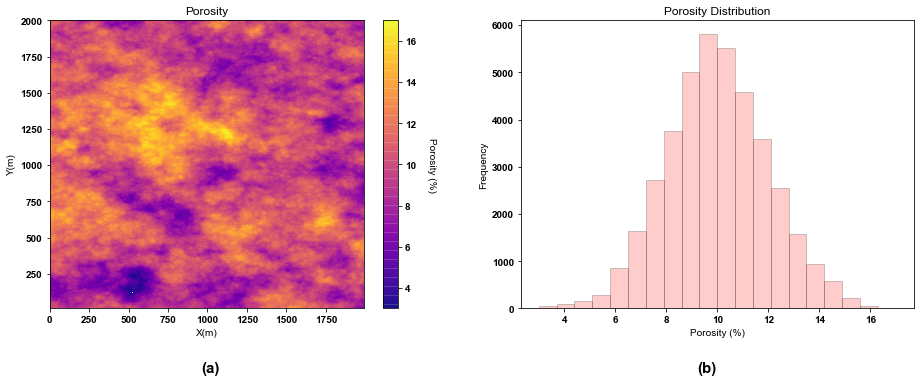

In [3]:
plt.subplot(121)
GSLIB.pixelplt_st(por,xmin,xmax,ymin,ymax,cell_size,vmin,vmax,"Porosity","X(m)","Y(m)","Porosity (%)",cmap)
plt.subplot(122)
GSLIB.hist_st(por.flatten(),vmin,vmax,log=False,cumul=False,bins=20,weights=None,xlabel="Porosity (%)",title="Porosity Distribution")
plt.subplots_adjust(left=0.0, bottom=0.0, right=2, top=1, wspace=0.2, hspace=0.2)
plt.gcf().text(0.35, -0.22, '(a)',fontsize=15, fontweight='bold',family='Arial')
plt.gcf().text(1.5, -0.22, '(b)',fontsize=15, fontweight='bold',family='Arial')
plt.savefig('Figure2.tif',dpi=300,bbox_inches="tight")

#### Sample from the univariate porosity model

In [4]:
nx = 200; ny = 200; cell_size = 10                               # grid number of cells and cell size
xmin = 0.0; ymin = 0.0;                                          # grid origin
xmax = xmin + nx * cell_size; ymax = ymin + ny * cell_size       # calculate the extent of model

mx = 25; my = 25
sample_data1 = regular_sample(por,xmin,xmax,ymin,ymax,cell_size,mx,my,"Porosity")
nsamp_random = 240
rand.seed(9002)
sample_data2 = random_sample(por,xmin,xmax,ymin,ymax,cell_size,nsamp_random,'Porosity')
sample_data = pd.concat([sample_data1,sample_data2],ignore_index = True)

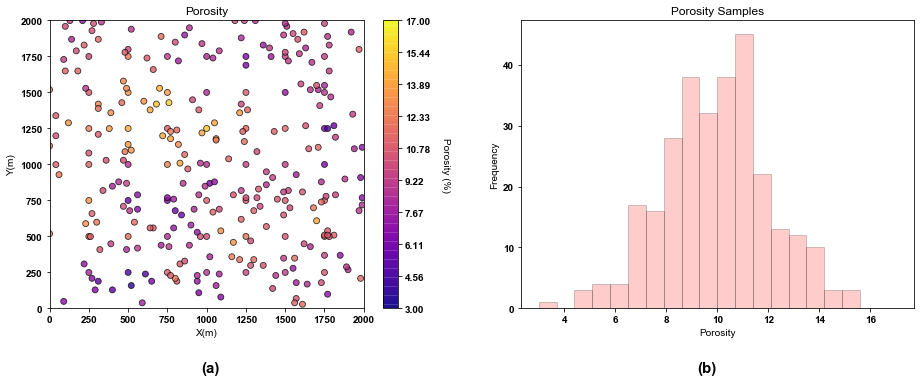

In [5]:
plt.subplot(121)
GSLIB.locmap_st(sample_data,'X','Y','Porosity',xmin,xmax,ymin,ymax,vmin,vmax,'Porosity','X(m)','Y(m)','Porosity (%)',cmap)
plt.subplot(122)
GSLIB.hist_st(sample_data['Porosity'],vmin,vmax,log=False,cumul=False,bins=20,weights=None,xlabel="Porosity",title="Porosity Samples")
plt.subplots_adjust(left=0.0, bottom=0.0, right=2, top=1, wspace=0.2, hspace=0.2)
plt.gcf().text(0.35, -0.22, '(a)',fontsize=15, fontweight='bold',family='Arial')
plt.gcf().text(1.5, -0.22, '(b)',fontsize=15, fontweight='bold',family='Arial')
plt.savefig('Figure3.tif',dpi=300,bbox_inches="tight")

#### Transform the spatial data feature (porosity) to standard Gaussian random function Z by normal score transformation.

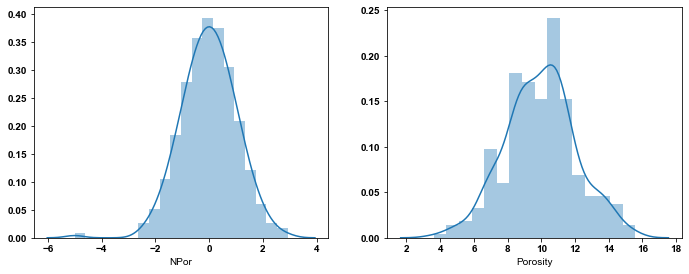

In [6]:
sample_data['NPor'], tvpor, tnspor = geostats.nscore(sample_data, 'Porosity')
plt.subplot(121)
sns.distplot(sample_data['NPor'], hist=True)
plt.subplot(122)
sns.distplot(sample_data['Porosity'], hist=True)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=0.8, wspace=0.2, hspace=0.2)

#### Calculate experimental variogram to see if trend exists

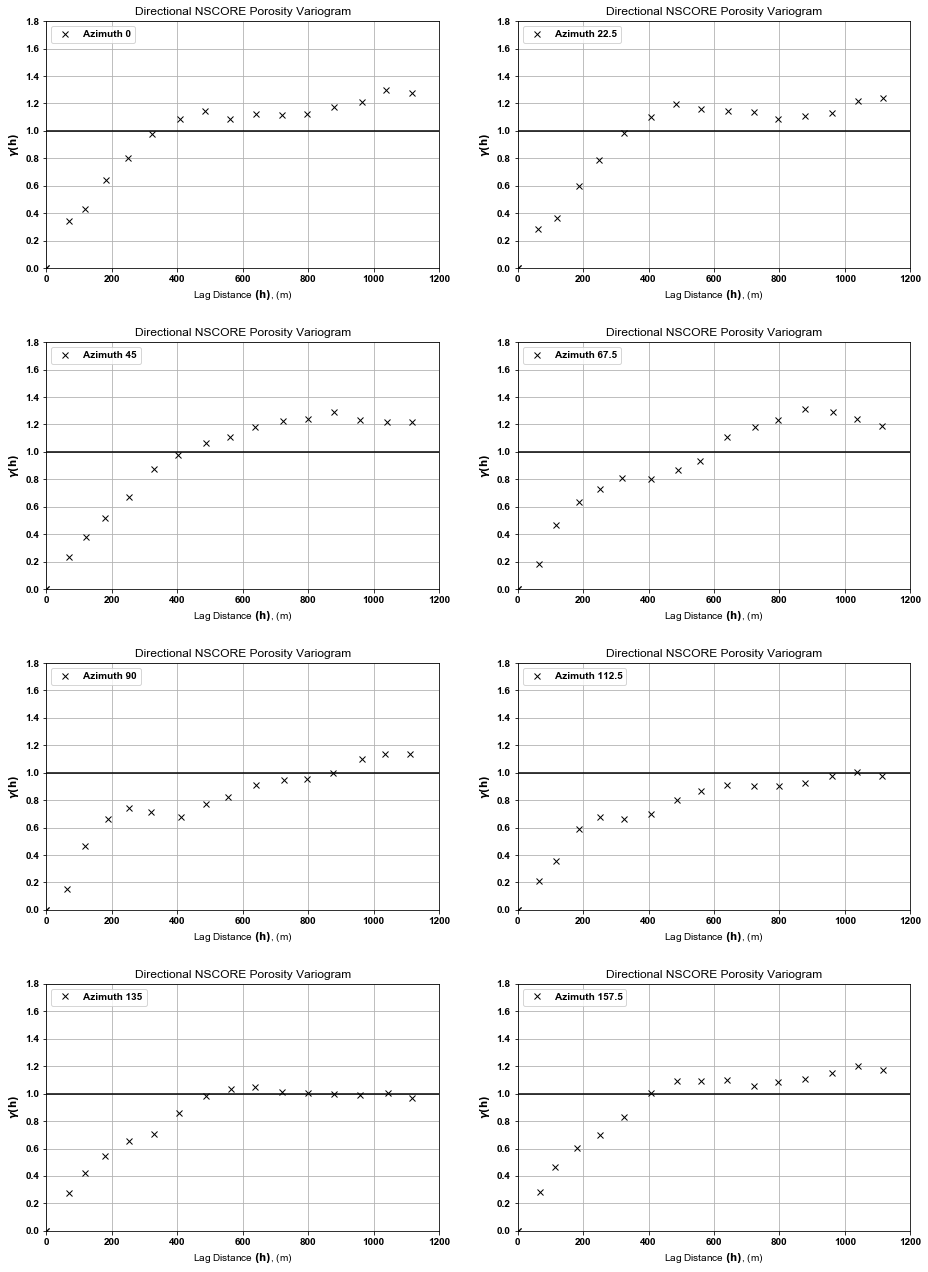

In [7]:
tmin = -9999.; tmax = 9999.                             # no trimming 
lag_dist = 80.0; lag_tol = 100.0; nlag = 15;            # maximum lag is 700m and tolerance > 1/2 lag distance for smoothing
bandh = 9999.9; atol = 22.5                             # no bandwidth, directional variograms
isill = 1  
azi_mat = [0,22.5,45,67.5,90,112.5,135,157.5]           # directions in azimuth to consider
# Arrays to store the results
lag = np.zeros((len(azi_mat),nlag+2)); gamma = np.zeros((len(azi_mat),nlag+2)); npp = np.zeros((len(azi_mat),nlag+2));

for iazi in range(0,len(azi_mat)):                      # Loop over all directions
    lag[iazi,:], gamma[iazi,:], npp[iazi,:] = geostats.gamv(sample_data,"X","Y","NPor",tmin,tmax,lag_dist,lag_tol,nlag,azi_mat[iazi],atol,bandh,isill)
    plt.subplot(4,2,iazi+1)
    plt.plot(lag[iazi,:],gamma[iazi,:],'x',color = 'black',label = 'Azimuth ' +str(azi_mat[iazi]))
    plt.plot([0,2000],[1.0,1.0],color = 'black')
    plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
    plt.ylabel(r'$\gamma \bf(h)$')
    plt.title('Directional NSCORE Porosity Variogram')
    plt.xlim([0,1200])
    plt.ylim([0,1.8])
    plt.legend(loc='upper left')
    plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=4.2, wspace=0.2, hspace=0.3)
plt.show()

#### Find major and minor direction and build the variogram model

 x,y,z offsets = 73.91036266959065,-30.61467442338038
 x,y,z offsets = 30.61467455604182,73.91036261464049


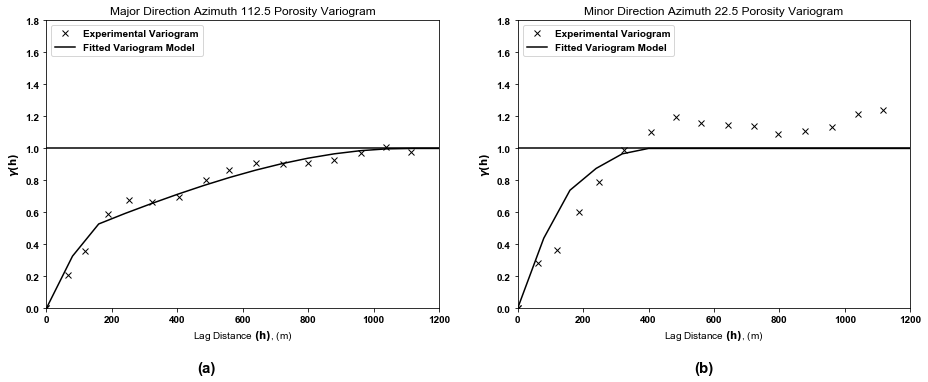

In [8]:
nug = 0.0; nst = 2                                             # 2 nest structure variogram model parameters
it1 = 1; cc1 = 0.4; azi1 = 112.5; hmaj1 = 170; hmin1 = 170
it2 = 1; cc2 = 0.6; azi2 = 112.5; hmaj2 = 1100; hmin2 = 400

vario = GSLIB.make_variogram(nug,nst,it1,cc1,azi1,hmaj1,hmin1,it2,cc2,azi2,hmaj2,hmin2) # make model object
nlag = 15; xlag = 80; azm = 112.5;                                # project the model in the 045 azimuth
index45,h112,gam112,cov45,ro45 = geostats.vmodel(nlag,xlag,azm,vario)
azm = 22.5                                                      # project the model in the 135 azimuth
index135,h22,gam22,cov135,ro135 = geostats.vmodel(nlag,xlag,azm,vario)

plt.subplot(1,2,1)
plt.plot(lag[5,:],gamma[5,:],'x',color = 'black',label = 'Experimental Variogram')
plt.plot([0,2000],[1.0,1.0],color = 'black',label = 'Fitted Variogram Model')
plt.plot(h112,gam112,color = 'black')
plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
plt.ylabel(r'$\gamma \bf(h)$')
plt.title('Major Direction Azimuth 112.5 Porosity Variogram')
plt.xlim([0,1200])
plt.ylim([0,1.8])
plt.legend(loc='upper left')

plt.subplot(1,2,2)
plt.plot(lag[1,:],gamma[1,:],'x',color = 'black',label = 'Experimental Variogram')
plt.plot([0,2000],[1.0,1.0],color = 'black',label = 'Fitted Variogram Model')
plt.plot(h22,gam22,color = 'black')
plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
plt.ylabel(r'$\gamma \bf(h)$')
plt.title('Minor Direction Azimuth 22.5 Porosity Variogram')
plt.xlim([0,1200])
plt.ylim([0,1.8])
plt.legend(loc='upper left')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2, top=1, wspace=0.2, hspace=0.3)
plt.gcf().text(0.35, -0.22, '(a)',fontsize=15, fontweight='bold',family='Arial')
plt.gcf().text(1.5, -0.22, '(b)',fontsize=15, fontweight='bold',family='Arial')
plt.savefig('Figure4.tif',dpi=300,bbox_inches="tight")

### 2. Anomaly Probability Calculation

#### Construct function to calculate biavariate gaussian distribution joint probability density function and anomaly probability 

In [9]:
def multi_gaussian(rho,head,tail):
    z = head**2-2*rho*head*tail+tail**2
    prob = np.exp(-z/(2*(1-rho**2)))/(2*np.pi*np.sqrt(1-rho))
    return prob

def p_value(nx,ny,rho,ztail,zhead):
    xx = np.linspace(-4, 4, nx)
    yy = np.linspace(-4, 4, ny)
    head,tail = np.meshgrid(xx,yy)
    prob = multi_gaussian(rho,head,tail)
    
    s = prob.sum()
    I = np.sort(prob,axis=None)[::-1]
    joint_density = 0
    times=0
    
    for i in range(len(I)):
        joint_density += I[i]/s
        if (i!=0)&(I[i-1] == I[i]):
            if (head[np.where(prob == I[i])][times+1]>=zhead)&(head[np.where(prob == I[i])][times+1]-8/(nx-1)<zhead)&(tail[np.where(prob == I[i])][times+1]>=ztail)&(tail[np.where(prob == I[i])][times+1]-8/(ny-1)<ztail):
                break
            times += 1 
        else:
            if (head[np.where(prob == I[i])][0]>=zhead)&(head[np.where(prob == I[i])][0]-8/(nx-1)<zhead)&(tail[np.where(prob == I[i])][0]>=ztail)&(tail[np.where(prob == I[i])][0]-8/(ny-1)<ztail):
                break
            times=0
    return 1-joint_density

In [10]:

def plot_vector(ax,df_tail,df_head,p,rho,i,j):
    df_mid.iloc[k_num*i+j,:]['X'] = (df_tail['X']+df_head['X'])/2
    df_mid.iloc[k_num*i+j,:]['Y'] = (df_tail['Y']+df_head['Y'])/2
    df_mid.iloc[k_num*i+j,:]['pvalue'] = p
    df_mid.iloc[k_num*i+j,:]['cova'] = rho
    df_mid.iloc[k_num*i+j,:]['porosity'] = (df_tail['Porosity']+df_head['Porosity'])/2
    if p <= 0.05:
        ax.plot([df_head['X'],df_tail['X']],[df_head['Y'],df_tail['Y']],'r-',alpha = 0.8)
    else:
        ax.plot([df_head['X'],df_tail['X']],[df_head['Y'],df_tail['Y']],'k-',alpha = 0.2)


### 1) Anomaly map with k-nearest neighbor data pair construction

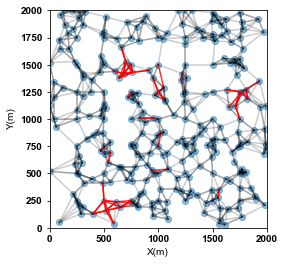

In [11]:
def euclidean_distance(df):
    """
    A simple euclidean distance function
    """
    return math.sqrt((df['X'] - data['X']) ** 2+(df['Y'] - data['Y']) ** 2)

k_num=5
nx = 50;ny = 50
fig=plt.figure()
ax=fig.add_subplot(111)
df_mid=pd.DataFrame(data={"pvalue": np.zeros((k_num*len(sample_data),)),"porosity": np.zeros((k_num*len(sample_data),)),"cova": np.zeros((k_num*len(sample_data),)),"X": np.zeros((k_num*len(sample_data),)),"Y": np.zeros((k_num*len(sample_data),))})
for rows, data in sample_data.iterrows():
    dist = sample_data.apply(lambda x: euclidean_distance(x), axis=1)
    # Create a new dataframe with distances.
    distance_frame = pd.DataFrame(data={"dist": dist})
    distance_frame.sort_values("dist", inplace=True)
    # Find the most similar (the lowest distance to the data is itself, the second smallest is the most similar ones)
    local_smallest = distance_frame.iloc[1:k_num+1].index
    nearest_neighbor = sample_data.loc[local_smallest]
    nearest_neighbor['dist'] = distance_frame.iloc[1:k_num+1].dist
    nearest_neighbor = nearest_neighbor.reset_index()
    for i,local in nearest_neighbor.iterrows():
        rho = correlavario(data['X'], data['Y'], local['X'], local['Y'])
        zhead = data['NPor']
        ztail = local['NPor']
        p = p_value(nx,ny,rho,ztail,zhead)
        plot_vector(ax,local,data,p,rho,rows,i)
ax.set_aspect('equal')
ax.scatter(sample_data['X'],sample_data['Y'],alpha=0.5)
ax.set_xlim(0, 2000)
ax.set_ylim(0, 2000)
ax.set_xlabel('X(m)')
ax.set_ylabel('Y(m)')
plt.savefig('5 nearestneighbor result.tif',dpi=300,bbox_inches="tight")

In [12]:
### take the average of the p value at the same location
df_map_kn = df_mid.groupby(['X','Y'], as_index=False).mean()


#### Anomaly kriging map from k-nearest neighbor data pair construction

In [25]:
nx = 100; ny = 100
xsiz = 20;ysiz = 20
tmin = -9999.; tmax = 9999.
xmn = xsiz * 0.5
ymn = ysiz * 0.5
ktype=1#ordinary kriging
nxdis = 1; nydis = 1                       # number of grid discretizations for block kriging (not tested)
ndmin = 0; ndmax = 30                      # minimum and maximum data for an estimate
map_mean=np.mean(df_map_kn.pvalue)  #won't be used if ktype = 1 i.e. ordinary kriging
###Kriging map for anomaly probability
nug = 0.15;nst = 2
it1 = 2; cc1 = 0.55;azi1 = 0; hmaj1 = 320; hmin1 =320
it2 = 3; cc2 = 0.25;azi2=0; hmaj2 = 650; hmin2 = 400
kn_map_vario = GSLIB.make_variogram(nug,nst,it1,cc1,azi1,hmaj1,hmin1,it2,cc2,azi2,hmaj2,hmin2)
radius = max(hmaj1, hmaj2)
est_kn,var_kn = geostats.kb2d(df_map_kn, 'X', 'Y', 'pvalue',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,nxdis,nydis,
         ndmin,ndmax,radius,ktype,map_mean,kn_map_vario)
#kb2d(df_map_kn, 'X', 'Y', 'pvalue', nx, ny, xsiz,ysiz, nug,nst,it1,cc1,azi1,hmaj1,hmin1, it2,cc2,azi2,hmaj2,hmin2,'output_file')


 make_variogram Warning: sill does not sum to 1.0, do not use in simulation 
  Estimated   10000 blocks 
      average   0.4821737369589458  variance  0.04329834947919542


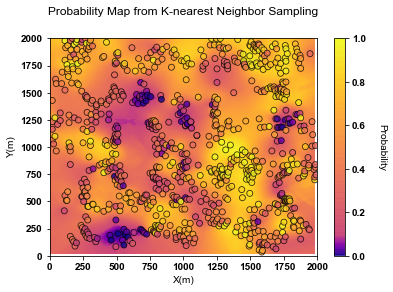

In [26]:
xmin=0;xmax=2000;ymin=0;ymax=2000
anomaly_map(est_kn,xmin,xmax,ymin,ymax,xsiz,0.0,1,df_map_kn,'X','Y','pvalue','Probability Map from K-nearest Neighbor Sampling','X(m)','Y(m)','Probability',cmap='plasma')

### 2) Anomaly map with Delaunay tessellation data pair construction 

In [27]:
def distance(arr1,arr2):##Input: simplex vertices coordinates
    """
    A simple euclidean distance function
    """
    return math.sqrt((arr1[0] - arr2[0]) ** 2+(arr1[1] - arr2[1]) ** 2)

def plot_centroid(df_tail,df_head,p,rho,i,j):

    df_mid.iloc[3*j+i,:]['X'] = (df_tail['X']+df_head['X'])/2
    df_mid.iloc[3*j+i,:]['Y'] = (df_tail['Y']+df_head['Y'])/2
    df_mid.iloc[3*j+i,:]['pvalue'] = p
    df_mid.iloc[3*j+i,:]['cova'] = rho
    df_mid.iloc[3*j+i,:]['porosity'] = (df_tail['Porosity']+df_head['Porosity'])/2
    if p <= 0.05:
        ax.plot([df_head['X'],df_tail['X']],[df_head['Y'],df_tail['Y']],'r-',alpha = 0.8)
    else:
        ax.plot([df_head['X'],df_tail['X']],[df_head['Y'],df_tail['Y']],'k-',alpha = 0.2)






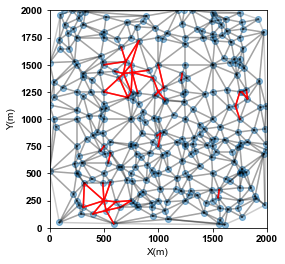

In [28]:
nx = 50;ny = 50
dist = np.zeros((3,))
points=sample_data.loc[:,['X','Y']].values
tri = Delaunay(points)
df_mid=pd.DataFrame(data={"pvalue": np.zeros((3*len(points[tri.simplices]),)),"porosity": np.zeros((3*len(points[tri.simplices]),)),"cova": np.zeros((3*len(points[tri.simplices]),)),"X": np.zeros((3*len(points[tri.simplices]),)),"Y": np.zeros((3*len(points[tri.simplices]),))})
j = 0
fig = plt.figure()
ax = fig.add_subplot(111)
for simplex in points[tri.simplices]:
    zhead = pd.DataFrame()
    ztail = pd.DataFrame()
    for i in range(3):
        if i!=2:
            dist[i] = distance(simplex[i],simplex[i+1])
            zhead = pd.concat([zhead,sample_data[(sample_data['X']==simplex[i][0])&(sample_data['Y']==simplex[i][1])]])
            ztail = pd.concat([ztail,sample_data[(sample_data['X']==simplex[i+1][0])&(sample_data['Y']==simplex[i+1][1])]])
        else:
            dist[i] = distance(simplex[i],simplex[0])
            zhead = pd.concat([zhead,sample_data[(sample_data['X']==simplex[i][0])&(sample_data['Y']==simplex[i][1])]])
            ztail = pd.concat([ztail,sample_data[(sample_data['X']==simplex[0][0])&(sample_data['Y']==simplex[0][1])]])
    for i in range(3):
        rho = correlavario(zhead.iloc[i,:]['X'], zhead.iloc[i,:]['Y'], ztail.iloc[i,:]['X'], ztail.iloc[i,:]['Y'])
#         cloud = correlated_var(rho,sample_data.NPor.values)
#         xmax=cloud[0].max();ymax=cloud[1].max();xmin=cloud[0].min();ymin=cloud[1].min()
#         p = p_value(nx,ny,xmin,xmax,ymin,ymax,cloud,ztail.iloc[i,:]['NPor'],zhead.iloc[i,:]['NPor'])
        p = p_value(nx,ny,rho,ztail.iloc[i,:]['NPor'],zhead.iloc[i,:]['NPor'])
        plot_centroid(ztail.iloc[i,:],zhead.iloc[i,:],p,rho,i,j)
    j+=1

ax.set_aspect('equal')
ax.scatter(sample_data['X'],sample_data['Y'],alpha=0.5)
ax.set_xlim(0, 2000)
ax.set_ylim(0, 2000)
ax.set_xlabel('X(m)')
ax.set_ylabel('Y(m)')
plt.savefig('tesselation result.tif',dpi=300,bbox_inches="tight")

In [29]:
### take the average of the p value at the same location
df_map = df_mid.groupby(['X','Y'], as_index=False).mean()

#### Anomaly kriging map from tessellation data pair construction

In [30]:
nx = 100; ny = 100
tmin = -9999.; tmax = 9999.
xsiz = 20;ysiz = 20
xmn = xsiz * 0.5
ymn = ysiz * 0.5
ktype = 1    #ordinary kriging
nxdis = 1; nydis = 1                       # number of grid discretizations for block kriging (not tested)
ndmin = 0; ndmax = 30                      # minimum and maximum data for an estimate
map_mean=np.mean(df_map_kn.pvalue)  #won't be used if ktype = 1 i.e. ordinary kriging
###Kriging map for Pvalue
nug = 0;nst = 2
it1 = 2; c1 = 0.7;azm_maj1 = 90; hmaj1 = 400; hmin1 =350
it2 = 2; c2 = 0.3;azm_maj2=90; hmaj2 = 650; hmin2 = 600
map_vario = GSLIB.make_variogram(nug,nst,it1,cc1,azi1,hmaj1,hmin1,it2,cc2,azi2,hmaj2,hmin2)
radius = max(hmaj1, hmaj2)

est,var = geostats.kb2d(df_map, 'X', 'Y', 'pvalue',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,nxdis,nydis,
         ndmin,ndmax,radius,ktype,map_mean,map_vario)

 make_variogram Warning: sill does not sum to 1.0, do not use in simulation 
  Estimated   10000 blocks 
      average   0.4708965545909372  variance  0.057542622273639904


In [31]:
#### Truncate estimated negative value to 0
est[np.where(est<0)] = np.zeros((est[np.where(est<0)].shape))
est_kn[np.where(est_kn<0)] = np.zeros((est_kn[np.where(est_kn<0)].shape))

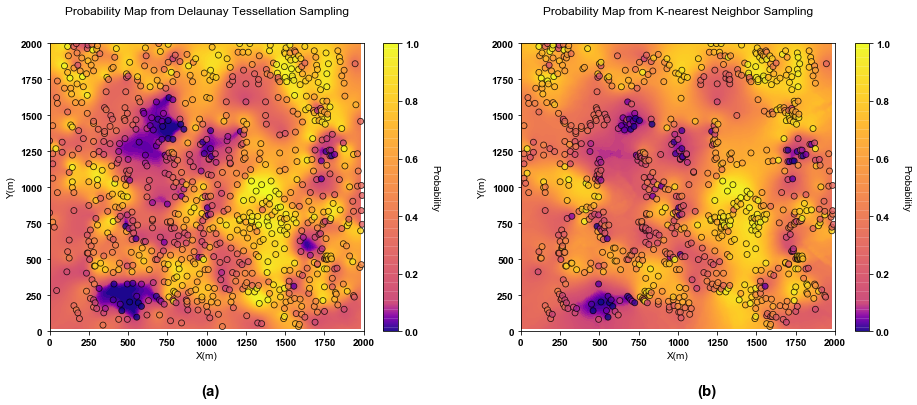

In [32]:
xmin=0;xmax=2000;ymin=0;ymax=2000
plt.subplot(121)
anomaly_map(est,xmin,xmax,ymin,ymax,xsiz,0.0,1,df_map,'X','Y','pvalue','Probability Map from Delaunay Tessellation Sampling','X(m)','Y(m)','Probability',cmap='plasma')
plt.subplot(122)
anomaly_map(est_kn,xmin,xmax,ymin,ymax,xsiz,0.0,1,df_map_kn,'X','Y','pvalue','Probability Map from K-nearest Neighbor Sampling','X(m)','Y(m)','Probability',cmap='plasma')
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2)
plt.gcf().text(0.35, -0.22, '(a)',fontsize=15, fontweight='bold',family='Arial')
plt.gcf().text(1.5, -0.22, '(b)',fontsize=15, fontweight='bold',family='Arial')
plt.savefig('Figure6.tif',dpi=300,bbox_inches="tight")

#### Compare the anomaly maps difference between k-nearest neighbor and Delaunay tessellation

In [33]:
def locpix_diff(
    array,
    xmin,
    xmax,
    ymin,
    ymax,
    step,
    vmin,
    vmax,
    title,
    xlabel,
    ylabel,
    vlabel,
    cmap,
):
    """Pixel plot and location map, reimplementation in Python of a GSLIB MOD
    with Matplotlib methods (version for subplots).
    :param array: ndarray
    :param xmin: x axis minimum
    :param xmax: x axis maximum
    :param ymin: y axis minimum
    :param ymax: y axis maximum
    :param step: step
    :param vmin: TODO
    :param vmax: TODO
    :param df: dataframe
    :param xcol: data for x axis
    :param ycol: data for y axis
    :param vcol: color, sequence, or sequence of color
    :param title: title
    :param xlabel: label for x axis
    :param ylabel: label for y axis
    :param vlabel: TODO
    :param cmap: colormap
    :return: QuadContourSet
    """
    xx, yy = np.meshgrid(
        np.arange(xmin, xmax, step), np.arange(ymax, ymin, -1 * step)
    )

    cs = plt.contourf(
        xx,
        yy,
        array,
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        levels=np.linspace(vmin, vmax, 100),
    )
   
#     plt.title(title,y=1.08)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    cbar =plt.colorbar(ticks=np.linspace(vmin,vmax,5))
    cbar.set_label(vlabel, rotation=270, labelpad=20)
    return cs

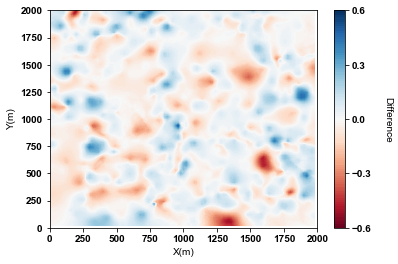

In [34]:
diff = est-est_kn
cmap = plt.cm.RdBu
locpix_diff(diff,xmin,xmax,ymin,ymax,xsiz,-0.6,0.6,'Anomaly Probability Difference Map','X(m)','Y(m)','Difference',cmap=cmap)
plt.savefig('Figure7.tif',dpi=300,bbox_inches="tight")

#### Evaluate the relationship between feature magnitude and anomaly probability 

In [35]:

por_bins = np.linspace(4,16,6)  # set the bin boundaries and then the centroids for plotting
por_centroids = np.linspace((por_bins[0]+por_bins[1])*0.5,(por_bins[4]+por_bins[5])*0.5,5)
print(por_bins,por_centroids)

[ 4.   6.4  8.8 11.2 13.6 16. ] [ 5.2  7.6 10.  12.4 14.8]


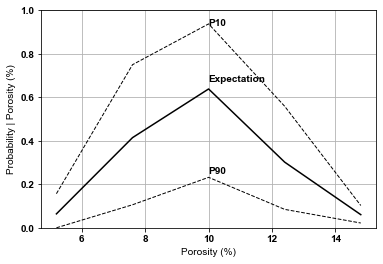

In [36]:

df_map['por_bins'] = pd.cut(df_map['porosity'],por_bins,labels=por_centroids)


cond_exp = df_map.groupby('por_bins')['pvalue'].mean()
cond_P90 = df_map.groupby('por_bins')['pvalue'].quantile(.9)
cond_P10 = df_map.groupby('por_bins')['pvalue'].quantile(.1)

plt.plot(por_centroids,cond_exp,color='black')
plt.plot(por_centroids,cond_P90,'r--',color='black',linewidth = 1.0)
plt.plot(por_centroids,cond_P10,'r--',color='black',linewidth = 1.0)
# plt.scatter(df_map['porosity'],df_map['pvalue'],alpha=0.4,edgecolor='white')
plt.xlabel('Porosity (%)')
plt.ylabel('Probability | Porosity (%)')
# t = plt.title('Anomaly Probability Conditional to Porosity')

plt.ylim((0,1))
plt.grid(True)

plt.text(10, 0.25, 'P90')
plt.text(10, 0.67, 'Expectation')
plt.text(10, 0.93, 'P10')
plt.savefig('Figure8.tif',dpi=300,bbox_inches="tight")


###  3. Account for dependence of spatial continuity on feature magnitude

#### Apply the indicator variogram for the bivariate Gaussian distribution to calculate anomaly probability instead of variogram

In [37]:
def funcf(x,z):
    """This function calculates the value of the function
    f( zc, xi)= exp ( -zc**2/ (1+sin(x))) for zc and x"""
    f = np.exp(-z**2/(1+np.sin(x)))
    return f

def funcg(x,z):
    g = np.exp(-x**2/2.0)
    return g


In [38]:
from scipy import integrate
def simpson(alim,blim,z,f):
    if alim == blim:
        value = 0
    elif blim>alim: 
        x = np.arange(alim,blim,0.001)
        y = f(x,z)
        value = integrate.simps(y,x)
    else:
        x = np.arange(alim,blim,-0.001)
        y = f(x,z)
        value = integrate.simps(y,x)
    return value

In [39]:
def gauinv(p):
    """
    p    = double precision cumulative probability value: dble(psingle)
    xp   = G^-1 (p) in single precision
    ierr = 1 - then error situation (p out of range), 0 - OK"""
    lim = 1.0e-10
    p0 = -0.322232431088;p1=-1.0; p2=-0.342242088547
    p3 = -0.0204231210245;p4=-0.0000453642210148
    q0 = 0.0993484626060; q1 = 0.588581570495; q2 = 0.531103462366
    q3 = 0.103537752850; q4 = 0.0038560700634
    ##Check for an error situation:
    ierr = 1
    if p<lim:
        xp = -1.0e10
        return p,xp,ierr
    if p>(1.0-lim):
        xp = 1.0e10
        return xp
    ierr = 0
    
    pp = p
    if p>0.5:
        pp = 1-pp
    xp = 0.0
    if p ==0.5:
        return xp
    y = np.sqrt(np.log(1.0/(pp*pp)))
    xp = y+((((y*p4+p3)*y+p2)*y+p1)*y+p0)/((((y*q4+q3)*y+q2)*y+q1)*y+q0)
    if p==pp:
        xp = -xp
    return xp


In [40]:

def bigaus(x1, y1, x2, y2, z_centroid, nst=2,c0=0,azi =90, it=[1,1],cc=[0.3,0.7],hmaj=[200,800],hmin = [120,500],hvert=[0,0]):
    """
    ncut:number of cutoffs
    zc: cutoffs, in ascending order"""
    ###Initialization
    rotmat = np.zeros((5, 3, 3))
    DEG2RAD = np.pi/180
    EPSLON = 1.0e-20
    MAXNST=4
    maxcov=1.0
    cmax = c0
    ang1 = np.ones((MAXNST,))*azi #azimuth
    ang2 = np.zeros((MAXNST,)) #dip
    ang3 = np.zeros((MAXNST,)) #plenge
    anis1 = np.zeros((MAXNST,))
    anis2 = np.zeros((MAXNST,))
    #### Set up the rotation matrices
    for i in range(nst):
        anis1[i] = hmin[i]/max(hmaj[i],EPSLON)
        anis2[i] = hvert[i]/max(hmaj[i],EPSLON)
        rotmat = setrot3(ang1[i],ang2[i],ang3[i],anis1[i],anis2[i],i,rotmat)
    #### Convert cutoffs cumulative probabilities to standard normal cutoffs:
# Here z_centroid is already a standard normal cutoff
    cmax,cova = cova3(x1,y1,0,x2,y2,0,nst,c0,it,cc,hmaj,rotmat,cmax)
    ro = cova/maxcov

    ci0 = simpson(0.0,np.pi/2,z_centroid,funcf)
    p = simpson(0.0,z_centroid,z_centroid,funcg)
    p = 0.5 + p/np.sqrt(2*np.pi)
    b = np.arcsin(ro)
    ci = simpson(0.0, b,z_centroid,funcf)
    ri = (ci0-ci)/(2*np.pi)
    rop = ri/(p*(1-p))
    c = 1-rop
    return c
            
            

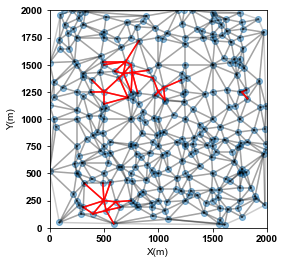

In [41]:
nx = 50;ny = 50
dist = np.zeros((3,))
df_mid=pd.DataFrame(data={"pvalue": np.zeros((3*len(points[tri.simplices]),)),"porosity": np.zeros((3*len(points[tri.simplices]),)),"cova": np.zeros((3*len(points[tri.simplices]),)),"X": np.zeros((3*len(points[tri.simplices]),)),"Y": np.zeros((3*len(points[tri.simplices]),))})
j = 0
fig=plt.figure()
ax=fig.add_subplot(111)
for simplex in points[tri.simplices]:
    zhead = pd.DataFrame()
    ztail = pd.DataFrame()
    for i in range(3):
        if i!=2:
            dist[i] = distance(simplex[i],simplex[i+1])
            zhead = pd.concat([zhead,sample_data[(sample_data['X']==simplex[i][0])&(sample_data['Y']==simplex[i][1])]])
            ztail = pd.concat([ztail,sample_data[(sample_data['X']==simplex[i+1][0])&(sample_data['Y']==simplex[i+1][1])]])
        else:
            dist[i] = distance(simplex[i],simplex[0])
            zhead = pd.concat([zhead,sample_data[(sample_data['X']==simplex[i][0])&(sample_data['Y']==simplex[i][1])]])
            ztail = pd.concat([ztail,sample_data[(sample_data['X']==simplex[0][0])&(sample_data['Y']==simplex[0][1])]])
    for i in range(3):
        z_centroid = (ztail.iloc[i,:]['NPor']+zhead.iloc[i,:]['NPor'])/2
        rho = bigaus(zhead.iloc[i,:]['X'], zhead.iloc[i,:]['Y'], ztail.iloc[i,:]['X'], ztail.iloc[i,:]['Y'],z_centroid)
#         cloud = correlated_var(rho,sample_data.NPor.values)
#         xmax=cloud[0].max();ymax=cloud[1].max();xmin=cloud[0].min();ymin=cloud[1].min()
#         p = p_value(nx,ny,xmin,xmax,ymin,ymax,cloud,ztail.iloc[i,:]['NPor'],zhead.iloc[i,:]['NPor'])
        p = p_value(nx,ny,rho,ztail.iloc[i,:]['NPor'],zhead.iloc[i,:]['NPor'])
        plot_centroid(ztail.iloc[i,:],zhead.iloc[i,:],p,rho,i,j)
    j+=1
ax.set_aspect('equal')
ax.scatter(sample_data['X'],sample_data['Y'],alpha=0.5)
ax.set_xlim(0, 2000)
ax.set_ylim(0, 2000)
ax.set_xlabel('X(m)')
ax.set_ylabel('Y(m)')
plt.savefig('Figure9.tif',dpi=300,bbox_inches="tight")

In [42]:
### take the average of the p value at the same location
df_map_bigaus = df_mid.groupby(['X','Y'], as_index=False).mean()

In [43]:

por_bins = np.linspace(4,16,6)  # set the bin boundaries and then the centroids for plotting
por_centroids = np.linspace((por_bins[0]+por_bins[1])*0.5,(por_bins[4]+por_bins[5])*0.5,5)
print(por_bins,por_centroids)

[ 4.   6.4  8.8 11.2 13.6 16. ] [ 5.2  7.6 10.  12.4 14.8]


Text(10, 0.7, 'P10')

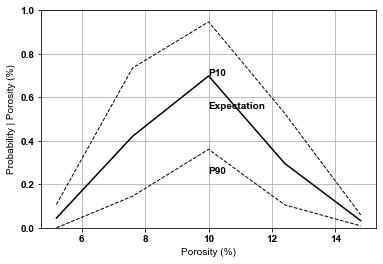

In [44]:

df_map_bigaus['por_bins'] = pd.cut(df_map_bigaus['porosity'],por_bins,labels=por_centroids)


cond_exp_bigaus = df_map_bigaus.groupby('por_bins')['pvalue'].mean()
cond_P90_bigaus = df_map_bigaus.groupby('por_bins')['pvalue'].quantile(.9)
cond_P10_bigaus = df_map_bigaus.groupby('por_bins')['pvalue'].quantile(.1)

plt.plot(por_centroids,cond_exp_bigaus,color='black')
plt.plot(por_centroids,cond_P90_bigaus,'r--',color='black',linewidth = 1.0)
plt.plot(por_centroids,cond_P10_bigaus,'r--',color='black',linewidth = 1.0)
# plt.scatter(df_map_bigaus['porosity'],df_map_bigaus['pvalue'],alpha=0.4,edgecolor='white')
plt.xlabel('Porosity (%)')
plt.ylabel('Probability | Porosity (%)')
# t = plt.title('Probability Conditional to Porosity')

plt.ylim((0,1))
plt.grid(True)

plt.text(10, 0.25, 'P90')
plt.text(10, 0.55, 'Expectation')
plt.text(10, 0.7, 'P10')



#### Compare anomaly probability difference from variogram and indicator variogram

In [45]:
import math
stats_n = df_map.groupby('por_bins')['pvalue'].agg(['mean', 'count', 'std'])
stats_bigaus = df_map_bigaus.groupby('por_bins')['pvalue'].agg(['mean', 'count', 'std'])


ci95_hi = []
ci95_lo = []

for i in range(5):
    m, c, s = stats_n.iloc[i]
    if c<100:
        ci95_hi.append(m + 2*s/math.sqrt(c))
        ci95_lo.append(m - 2*s/math.sqrt(c))
    else:
        ci95_hi.append(m + 1.96*s/math.sqrt(c))
        ci95_lo.append(m - 1.96*s/math.sqrt(c))

stats_n['ci95_hi'] = ci95_hi
stats_n['ci95_lo'] = ci95_lo

ci95_hi = []
ci95_lo = []

for i in range(5):
    m, c, s = stats_bigaus.iloc[i]
    if c<100:
        ci95_hi.append(m + 2.06*s/math.sqrt(c))
        ci95_lo.append(m - 2.06*s/math.sqrt(c))
    else:
        ci95_hi.append(m + 1.96*s/math.sqrt(c))
        ci95_lo.append(m - 1.96*s/math.sqrt(c))

stats_bigaus['ci95_hi'] = ci95_hi
stats_bigaus['ci95_lo'] = ci95_lo

In [46]:
stats_n

,mean,count,std,ci95_hi,ci95_lo
por_bins,,,,,
5.2,0.064043,18,0.061392,0.092983,0.035103
7.6,0.414590,193,0.230758,0.447146,0.382034
10.0,0.638497,437,0.260911,0.662960,0.614034
12.4,0.301939,169,0.176288,0.328517,0.275360
14.8,0.060449,27,0.035534,0.074126,0.046771


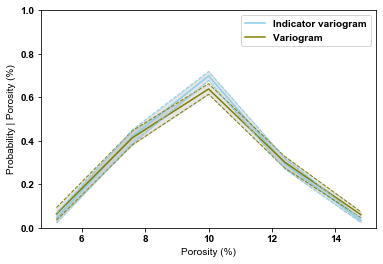

In [47]:
plt.plot(por_centroids,cond_exp_bigaus,color='skyblue',label='Indicator variogram')
plt.plot(por_centroids,cond_exp,color='olive',label='Variogram')
plt.plot(por_centroids,stats_n['ci95_lo'],'--',color='olive',linewidth = 1.0)
plt.plot(por_centroids,stats_n['ci95_hi'],'--',color='olive',linewidth = 1.0)
plt.fill_between(por_centroids,stats_n['ci95_lo'],stats_n['ci95_hi'],color='grey',alpha=0.2)
plt.plot(por_centroids,stats_bigaus['ci95_lo'],'--',color='skyblue',linewidth = 1.0)
plt.plot(por_centroids,stats_bigaus['ci95_hi'],'--',color='skyblue',linewidth = 1.0)
plt.fill_between(por_centroids,stats_bigaus['ci95_lo'],stats_bigaus['ci95_hi'],color='grey',alpha=0.2)

plt.xlabel('Porosity (%)')
plt.ylabel('Probability | Porosity (%)')
# t = plt.title('Anomaly Probability Conditional to Porosity')
plt.ylim((0,1))
plt.legend()
plt.savefig('Figure10.tif',dpi=300,bbox_inches="tight")

In [48]:
nx = 100; ny = 100
xsiz = 20;ysiz = 20
tmin = -9999.; tmax = 9999.
xmn = xsiz * 0.5
ymn = ysiz * 0.5
ktype = 1    #ordinary kriging
nxdis = 1; nydis = 1                       # number of grid discretizations for block kriging (not tested)
ndmin = 0; ndmax = 30                      # minimum and maximum data for an estimate
map_mean=np.mean(df_map_bigaus.pvalue)  #won't be used if ktype = 1 i.e. ordinary kriging
###Kriging map for Pvalue
nug = 0;nst = 2
it1 = 2; cc1 = 0.7;azi1 = 112.5; hmaj1 = 400; hmin1 =350
it2 = 1; cc2 = 0.3;azi2=112.5; hmaj2 = 800; hmin2 = 450
bigaus_map_vario = GSLIB.make_variogram(nug,nst,it1,cc1,azi1,hmaj1,hmin1,it2,cc2,azi2,hmaj2,hmin2)
radius = max(hmaj1, hmaj2)

est_bigaus,var_bigaus  = geostats.kb2d(df_map_bigaus, 'X', 'Y', 'pvalue',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,nxdis,nydis,
         ndmin,ndmax,radius,ktype,map_mean,bigaus_map_vario)


  Estimated   10000 blocks 
      average   0.4947030111197866  variance  0.061776651632416635


In [49]:
#### Truncate estimated negative value to 0
est_bigaus[np.where(est_bigaus<0)] = np.zeros((est_bigaus[np.where(est_bigaus<0)].shape))
# est_kn[np.where(est_kn<0)] = np.zeros((est_kn[np.where(est_kn<0)].shape))

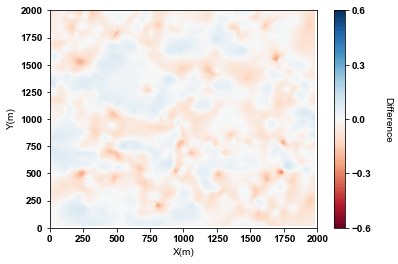

In [50]:
diff_bigaus = est-est_bigaus
cmap = plt.cm.RdBu
locpix_diff(diff_bigaus,xmin,xmax,ymin,ymax,xsiz,-0.6,0.6,'Anomaly Probability Difference Map','X(m)','Y(m)','Difference',cmap=cmap)
plt.savefig('Figure11.tif',dpi=300,bbox_inches="tight")

### Summary

The proposed hybrid spatial anomaly detection method integrates geoscience and engineering expertise via trend modeling and variogram modeling to assist data-driven spatial segmentation. 

The use of variogram models, converted to correlograms combined with the bivariate Gaussian distribution of the h-scatter plot, provide a practical method to assess a pairwise spatial sample data joint probability density function and to assign a useful probability for the occurrence of a specific pair of sample data. The influence of the relation between spatial continuity and feature magnitude on the lag joint probability density function is included by integrating the indicator correlogram to update the standard correlogram. 

After comparing results from the proposed spatial anomaly detection method with different data pair construction and different variogram approaches, we find the output anomaly map is more sensitive to proper data pairs construction with better coverage of area of interest (e.g. Delaunay tessellation) than feature magnitude for the demonstration case. 